<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A análise tem como objetivo entender a distribuição espacial e operacional das entregas no Distrito Federal, com foco em três hubs logísticos distintos. Utilizando dados geoespaciais e técnicas de análise exploratória, buscamos identificar padrões, gargalos e oportunidades de otimização na operação de entregas.

## 2\. Pacotes e bibliotecas

In [1]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [1]:
# importe todas as suas bibliotecas aqui, siga os padrões do PEP8:
#
# - 1º pacotes nativos do python: json, os, etc.;
# - 2º pacotes de terceiros: pandas, seabornm etc.;
# - 3º pacotes que você desenvolveu.
#

...
# Pacotes nativos:

import json
import os

# Pacotes de terceiros:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Configuração geral o sns:
sns.set_theme()

## 3\. Exploração de dados

3.1 Coleta e carregamento:

In [2]:
# Dados principais:

with open("deliveries.json", "r", encoding="utf-8") as file:
    data = json.load(file)

deliveries_df = pd.read_json("deliveries.json")
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


3.2 Processamento do dado bruto e construção do DataFramde Pandas, em seguida as operações de flatten e explode:

In [4]:
# dado bruto no pandas

deliveries_df = pd.DataFrame(data)

# coluna origin

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# coluna deliveries

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


3.3 Estrutura e schema:

In [5]:
# Avaliando as dimensões do DataFrame:
deliveries_df.shape

(636149, 8)

In [6]:
# Resumo das informações do deliveries_df. Número delinhas e colunas, tipos de dados e verificação de valores nulos.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [9]:
# Visualizar os rótulos das colunas do deliveries_df.
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [10]:
# Visualizar o tipo de dados de cada coluna.
deliveries_df.dtypes

,0
name,object
region,object
hub_lng,float64
hub_lat,float64
vehicle_capacity,int64
delivery_size,int64
delivery_lng,float64
delivery_lat,float64


In [11]:
# Visualizar o identificar de cada linha.
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [12]:
# Gerar estatísticas descritivas do DataFrame.
deliveries_df.describe()

,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
count,636149.000000,636149.000000,636149.0,636149.000000,636149.000000,636149.000000
mean,-47.949902,-15.802359,180.0,5.512111,-47.946087,-15.809492
std,0.091875,0.053463,0.0,2.874557,0.112769,0.082462
min,-48.054989,-15.838145,180.0,1.000000,-48.280779,-16.050028
25%,-48.054989,-15.838145,180.0,3.000000,-48.035911,-15.842795
50%,-47.893662,-15.805118,180.0,6.000000,-47.928967,-15.814033
75%,-47.893662,-15.805118,180.0,8.000000,-47.883394,-15.769516
max,-47.802665,-15.657014,180.0,10.000000,-47.310611,-15.500355


In [13]:
# Visualizar e somar o número de valores ausentes em cada coluna.
deliveries_df.isna().sum()

,0
name,0
region,0
hub_lng,0
hub_lat,0
vehicle_capacity,0
delivery_size,0
delivery_lng,0
delivery_lat,0


3.4 Pré-processamento de hubs:

In [14]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


## 4\. Manipulação

4.1 Geocodificação reversa:

In [16]:
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

# Criando as coordenadas, armazenando os valores e processando com o geocoder.
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + "," + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248,-47.802664728268745","(Rua 7, Quadra 2, Vila DNOCS, Sobradinho, Regi..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334,-47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274,-48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Setor B S..."


In [18]:
# Normalizar as informações do geodata.
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number,address.quarter
0,14416233,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.6569160,-47.8026446,highway,secondary,26,0.053411,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,14619249,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.8051728,-47.8937235,highway,residential,26,0.053411,...,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN,NaN
2,11654896,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000051,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8,Setor B Sul


In [19]:
# Alterando as informações de rótulos.
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-19-f903bddb9805>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-19-f903bddb9805>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-19-f903bddb9805>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Vila DNOCS,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga Centro,Taguatinga


In [24]:
# Juntar os dois DataFrames com as informações que coletamos.
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Vila DNOCS,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga Centro,Taguatinga


4.2 Trabalhando com as informações das entregas:

In [25]:
# Baixando os dados:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [27]:
# Criando o DataFrame:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [28]:
# Juntando as informações dos dois DataFrame:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


4.3 Controle de qualidade:

In [29]:
# Avaliações de qualidade:
print(deliveries_df.isna().sum())
print(f"Delivery city missing: {100 * deliveries_df['delivery_city'].isna().sum() / len(deliveries_df):.2f}%")
print(f"Delivery suburb missing: {100 * deliveries_df['delivery_suburb'].isna().sum() / len(deliveries_df):.2f}%")

name                     0
region                   0
hub_lng                  0
hub_lat                  0
vehicle_capacity         0
delivery_size            0
delivery_lng             0
delivery_lat             0
delivery_city         1702
delivery_suburb     159885
dtype: int64
Delivery city missing: 0.27%
Delivery suburb missing: 25.13%


## 5\. Visualização

5.1 Mapa geoespacial das entregas:

In [ ]:
# Baixar e carregar o mapa do DF
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

In [44]:
# DataFrames geoespaciais
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [45]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.1149 -15.85805)


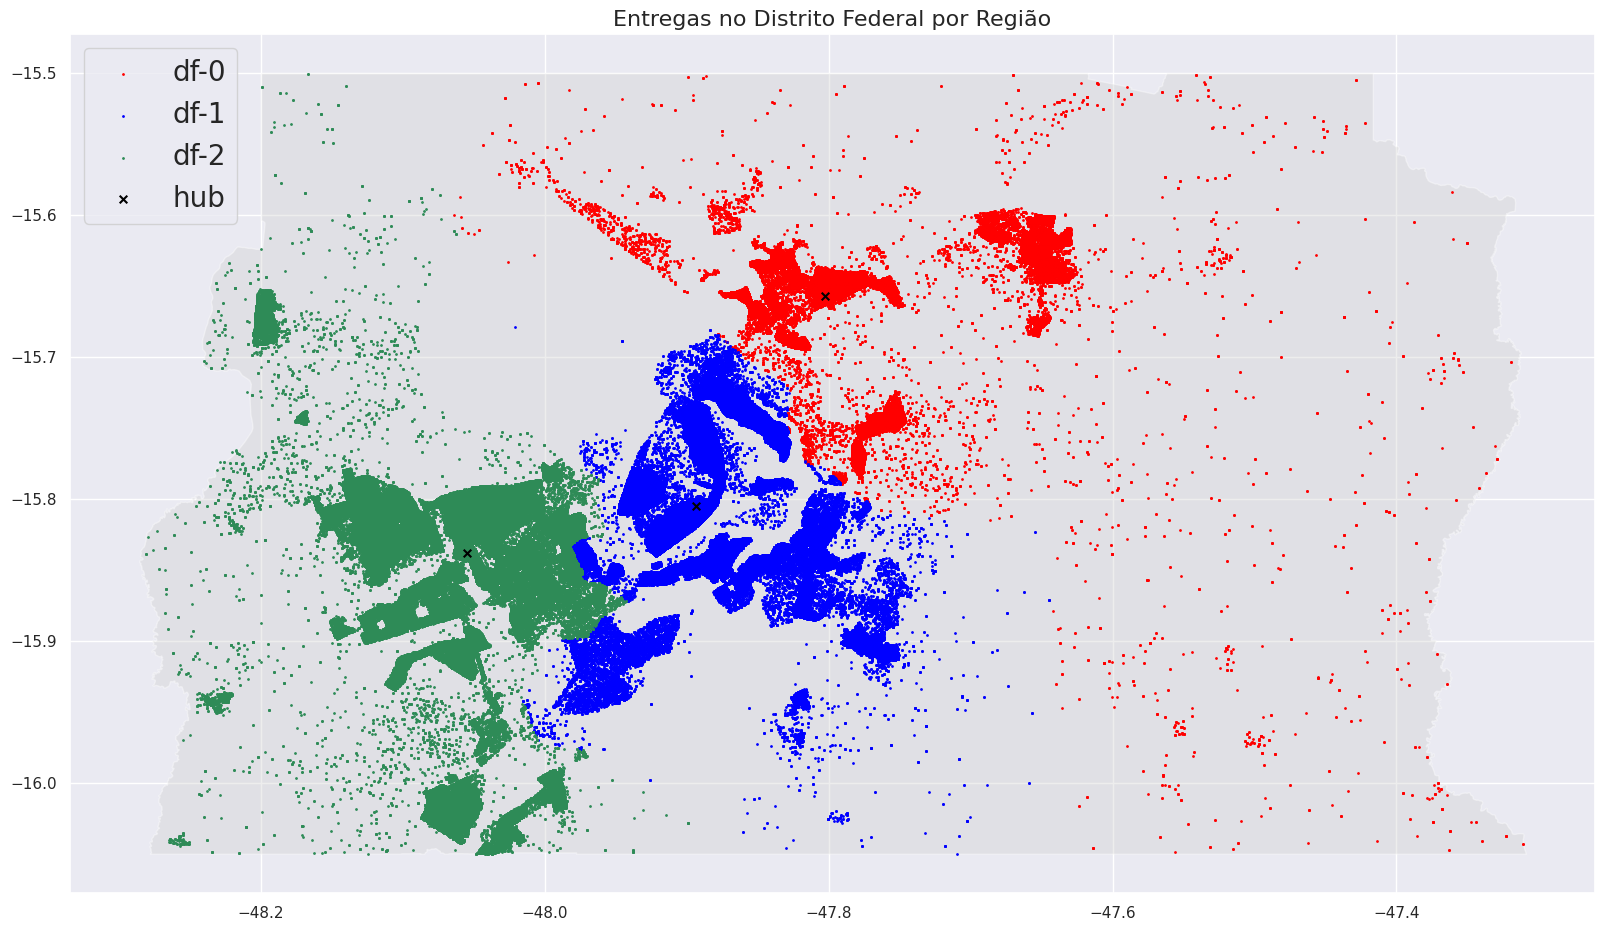

In [46]:
# Plotando as figuras:

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 20})

 Insight:

Os hubs estão alocados de forma coerente com as entregas.

Algumas entregas estão muito distantes do centro logístico, o que pode indicar rotas pouco eficientes.

Os hubs das regiões 0 e 2 fazem entregas em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.


5.2 Proporção de entregas por região:

<ipython-input-52-fc52fe6aaa8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_data, x="region", y="region_percent", palette="pastel")


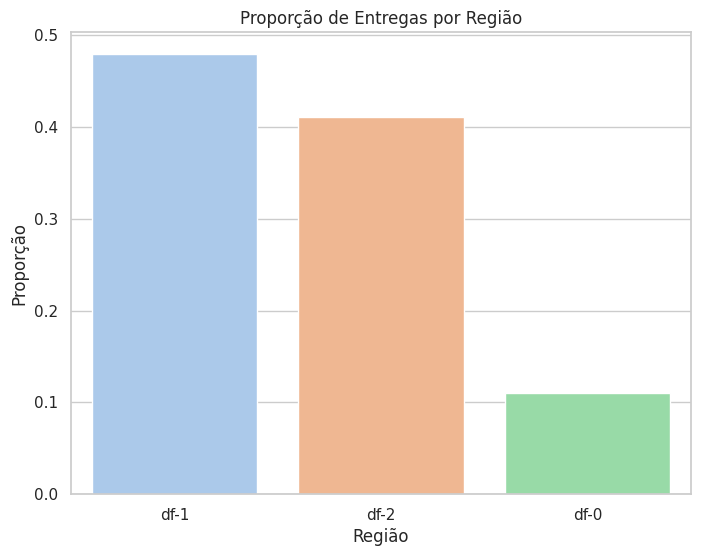

In [52]:
region_data = deliveries_df["region"].value_counts(normalize=True).reset_index()
region_data.columns = ["region", "region_percent"]

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=region_data, x="region", y="region_percent", palette="pastel")
    plt.title("Proporção de Entregas por Região")
    plt.xlabel("Região")
    plt.ylabel("Proporção")
    plt.show()

 Insight:

A região df-1 concentra a maior parte das entregas.

A região df-0 tem baixa demanda, mas capacidade veicular igual — o que sugere realocação de recursos.

6. Conclusões
Nesta análise exploratória de logística:

Validamos que as entregas estão coerentes com os hubs;

Identificamos a concentração desproporcional em algumas regiões;

Apontamos possíveis melhorias operacionais como redistribuição de frota ou relocação de hubs.

* Mapa com as rotas de entrega (linha entre hubs e destinos)

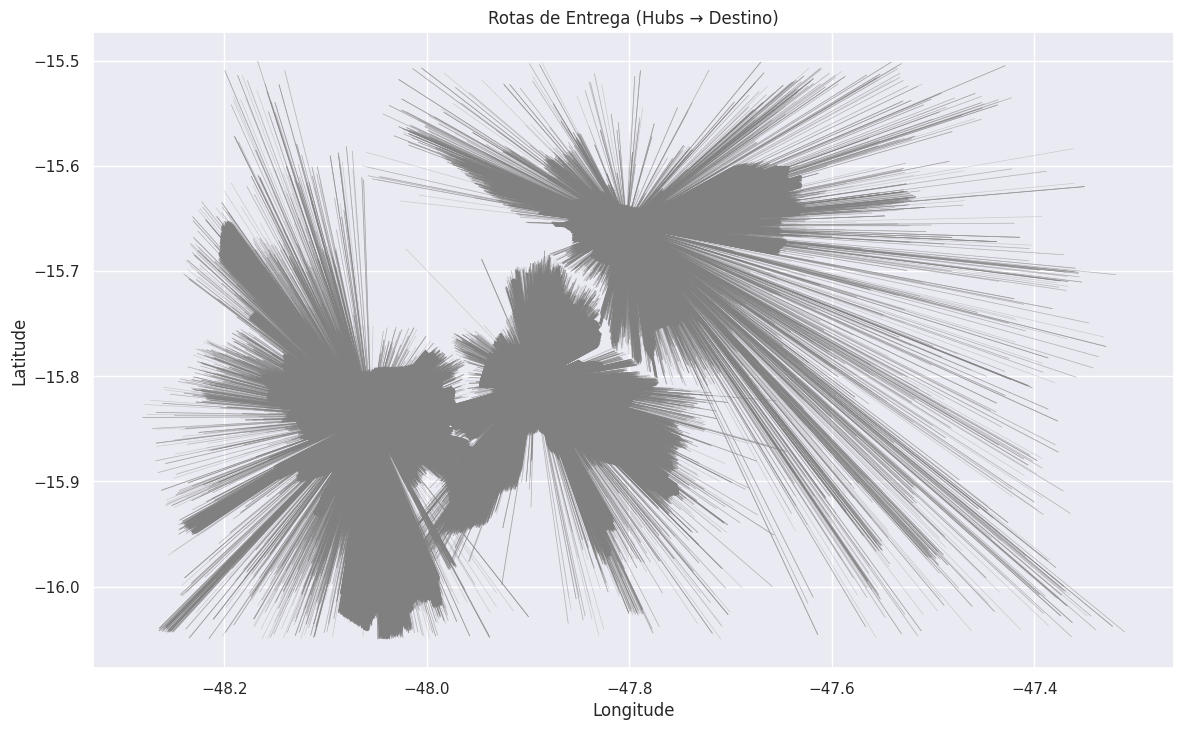

In [59]:
import geopandas as gpd
from shapely.geometry import LineString

# Criar linhas de hubs para destino
lines = []
for _, row in deliveries_df.iterrows():
    line = LineString([
        (row["hub_lng"], row["hub_lat"]),
        (row["delivery_lng"], row["delivery_lat"])
    ])
    lines.append(line)

routes_gdf = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
routes_gdf.plot(ax=ax, linewidth=0.5, alpha=0.3, color='gray')
plt.title("Rotas de Entrega (Hubs → Destino)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

Possíveis insights:

1. Distância média entre hub e destino.
2. Possíveis gargalos da rota.

* Mapa de Cluster de Entrega.
Agrupando entregas em regiões similares com base geográfica.

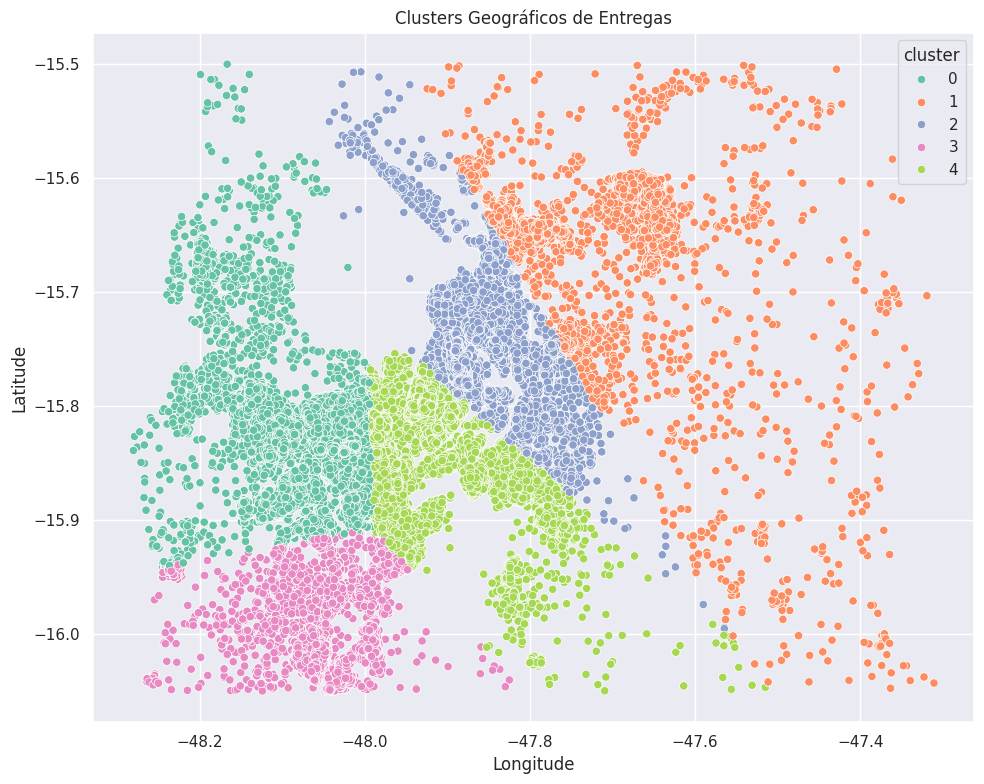

In [61]:
from sklearn.cluster import KMeans

coords = deliveries_df[["delivery_lat", "delivery_lng"]]
kmeans = KMeans(n_clusters=5, random_state=42)
deliveries_df["cluster"] = kmeans.fit_predict(coords)

# Plot com seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=deliveries_df, x="delivery_lng", y="delivery_lat", hue="cluster", palette="Set2")
plt.title("Clusters Geográficos de Entregas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()